### model training


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score , confusion_matrix , precision_recall_curve

# --- Imports for Neural Network ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

# Imbalanced-learn for handling class imbalance correctly in pipelines
from imblearn.pipeline import Pipeline as ImbPipeline

# Model Explainability
import shap

# Configure settings for cleaner output
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Set random seed for reproducibility
tf.random.set_seed(42)

c:\Users\PC\BankMarketing\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/eda_data.csv' )
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.shape

(39404, 20)

In [4]:
# Mapping dictionary
mapping = {"yes": 1, "no": 0}

# Apply mapping 

df['y'] = df['y'].map(mapping)


In [5]:
X = df.drop(columns=['y'],axis=1)
y = df['y']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int64

#### train test split

In [6]:
# Stratified split ensures the proportion of the target class is the same across all sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_validate, X_test, y_validate, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_validate.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (27582, 19)
Validation set shape: (5911, 19)
Test set shape: (5911, 19)


#### Data Preprocessing Pipeline Setup And models dictionary

In [7]:
# Identify column types 
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Create the preprocessor to scale numeric features and one-hot encode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)



#### Define the Neural Network Architecture 

In [8]:
# First, let's determine the input shape after preprocessing
# This is a crucial step for the NN's input layer
X_train_processed = preprocessor.fit_transform(X_train)
n_features = X_train_processed.shape[1]
print(f"Number of features after preprocessing: {n_features}\n")

# We create a function that builds the Keras model.
# This is required for the scikeras wrapper.
def create_nn_model(input_dim):
    """Creates a Keras Sequential model for binary classification."""
    model = Sequential([
        # Input layer: Must match the number of features
        Input(shape=(input_dim,)),
        
        # Hidden layer 1: A good starting point with ReLU activation
        Dense(64, activation='relu'),
        # Dropout layer to prevent overfitting
        Dropout(0.3),
        
        # Hidden layer 2: Deeper network can learn more complex patterns
        Dense(32, activation='relu'),
        Dropout(0.3),
        
        # Output layer: Single neuron with sigmoid for binary output (0 or 1)
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC', 'Precision', 'Recall']
    )
    return model



Number of features after preprocessing: 62



####  Set up the Training Pipeline 

In [9]:
# Callback to stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True # Restores model weights from the epoch with the best val_loss
)

# Wrap the Keras model using KerasClassifier to make it scikit-learn compatible
# Note: We pass the model-building function, not an instantiated model.
nn_classifier = KerasClassifier(
    model=lambda: create_nn_model(n_features),
    epochs=100,
    batch_size=64,
    verbose=1, # Set to 1 to see training progress
    validation_split=0.1, # Use 10% of training data for validation in each epoch
    callbacks=[early_stopping]
)


nn_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', nn_classifier)
])

#### Train the Model 

In [10]:

print("--- Starting Neural Network Training ---")
# Fit the entire pipeline on the training data.
# The pipeline handles preprocessing and resampling automatically.
nn_pipeline.fit(X_train, y_train)
print("\n Training complete.")

--- Starting Neural Network Training ---
Epoch 1/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6660 - Precision: 0.3572 - Recall: 0.1523 - loss: 0.3819 - val_AUC: 0.7859 - val_Precision: 0.6117 - val_Recall: 0.1909 - val_loss: 0.2965
Epoch 2/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7654 - Precision: 0.6231 - Recall: 0.2145 - loss: 0.3022 - val_AUC: 0.7914 - val_Precision: 0.5980 - val_Recall: 0.1848 - val_loss: 0.2940
Epoch 3/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7718 - Precision: 0.6458 - Recall: 0.2288 - loss: 0.2970 - val_AUC: 0.7912 - val_Precision: 0.6226 - val_Recall: 0.2000 - val_loss: 0.2938
Epoch 4/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7782 - Precision: 0.6724 - Recall: 0.2217 - loss: 0.2933 - val_AUC: 0.7925 - val_Precision: 0.6237 - val_Recall: 0.1758 - val_loss: 0.2928
Epoch 5/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7748 - Precision: 0.6689 - Recall: 0.2165 - loss: 0.2934 - val_AUC: 0.7920 - val_Precision: 0


--- Finding Optimal Threshold on Validation Set (Neural Network) ---
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 Maximum Profit on Validation Set: $20332.00
 Best Threshold for Max Profit: 0.1012


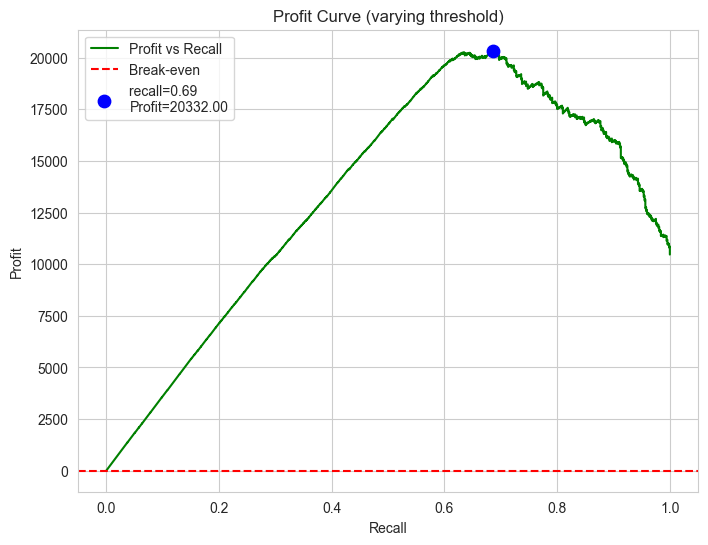

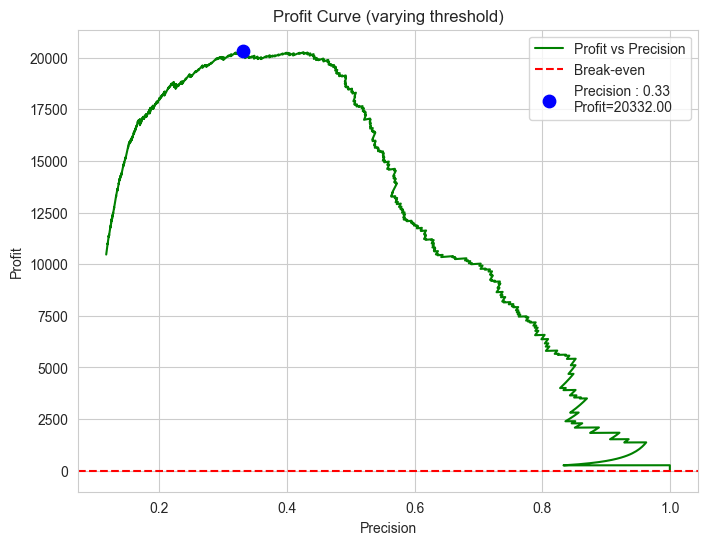

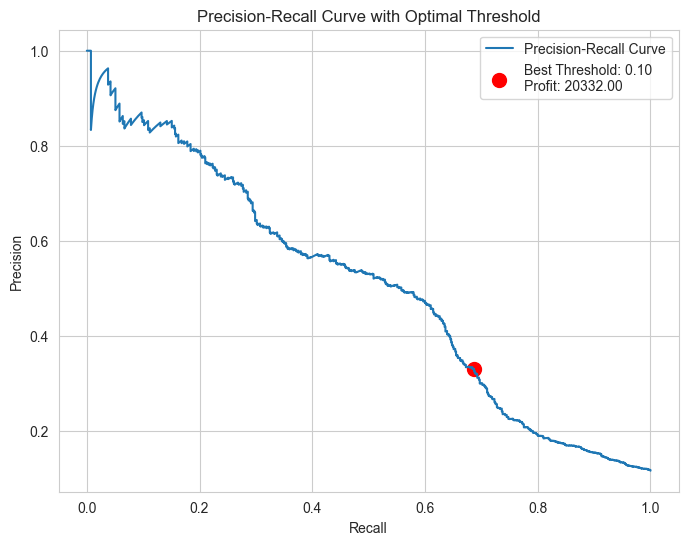


--- Final Report on Test Set (Optimized Threshold = 0.1012) ---
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
                 precision    recall  f1-score   support

No Subscription       0.95      0.81      0.88      5222
   Subscription       0.33      0.69      0.44       689

       accuracy                           0.80      5911
      macro avg       0.64      0.75      0.66      5911
   weighted avg       0.88      0.80      0.83      5911



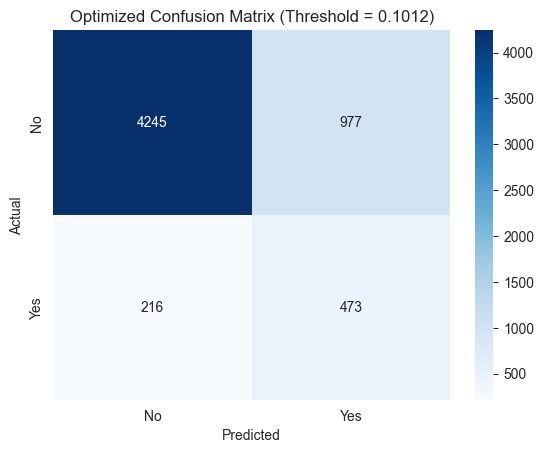

In [11]:
# ---  Finding the Optimal Threshold for the Neural Network ---
print("\n--- Finding Optimal Threshold on Validation Set (Neural Network) ---")

# First, get the prediction probabilities on the VALIDATION data
y_val_proba_nn = nn_pipeline.predict_proba(X_validate)[:, 1]

# Define business metrics

# marketing_cost per call
# Affected by TP and FP --> we make call to both , 1.actual true and predicted true , 2. actual false but predicted true)
call_cost = 5.0  # (including labor & infrastructure)

# this cost are affect after customer Acquisition (agree for subscription)(only Affected by TP-actual true and predicted true )
# Onboarding & KYC verification cost
onboarding_cost = 5
#Account management costs(back-office ops, compliance)
acc_cost = 15
# Other overheads(like customer support): 
other_overheads = 10
total_customer_cost = onboarding_cost + acc_cost + other_overheads  # Total acquisition cost

# calculating revenue per costomer (only Affected by TP-actual true and predicted true )
# Average deposit amount = 4000
# Interest spread(Interest Earned by Bank on Loans or Investments − Interest Paid to Customer on Deposit) = 2.2% annually
# Customer holds deposit for 1 year
subscription_revenue = 88 # (4000 * 0.022)

# Calculate precision, recall, and thresholds for the validation set
precisions, recalls, thresholds = precision_recall_curve(y_validate, y_val_proba_nn)

# To avoid division by zero
valid_precisions = np.maximum(precisions, 1e-8)
calls_made = (recalls * sum(y_validate)) / valid_precisions
#total profit = total_revenue - total_cost(cost of handling + marketing)
profit = (recalls * sum(y_validate) * subscription_revenue) - (recalls * sum(y_validate) * total_customer_cost) - (calls_made * call_cost)

# Find the threshold that maximizes profit.
# Note: thresholds array is one element shorter than recalls and precisions.
best_threshold_nn = thresholds[np.argmax(profit[:-1])]
max_profit = np.max(profit[:-1])

print(f" Maximum Profit on Validation Set: ${max_profit:.2f}")

# Find the threshold that corresponds to the maximum profit
best_threshold = thresholds[np.argmax(profit)]
print(f" Best Threshold for Max Profit: {best_threshold:.4f}")


# True positives and predicted positives at each point
total_pos = sum(y_validate)
TP = recalls * total_pos
pred_pos = np.divide(TP, np.maximum(precisions, 1e-8))  # calls made

best_idx = np.argmax(profit)

# Find index of max profit for point of curves

max_idx = np.argmax(profit)
max_recall = recalls[max_idx]
max_precision = precisions[max_idx]
max_profit = profit[max_idx]

# === Profit Curve ===
plt.figure(figsize=(8,6))
plt.plot(recalls, profit, label="Profit vs Recall", color="green")
plt.axhline(0, color="red", linestyle="--", label="Break-even")
plt.scatter(max_recall, max_profit, color="blue", s=80, zorder=5, 
            label=f"recall={max_recall:.2f} \nProfit={max_profit:.2f}")
plt.xlabel("Recall")
plt.ylabel("Profit")
plt.title("Profit Curve (varying threshold)")
plt.grid(True)
plt.legend()
plt.show()


# Plot
plt.figure(figsize=(8,6))
plt.plot(precisions, profit, label="Profit vs Precision", color="green")
plt.axhline(0, color="red", linestyle="--", label="Break-even")
plt.scatter(max_precision, max_profit, color="blue", s=80, zorder=5, 
            label=f"Precision : {max_precision:.2f} \nProfit={max_profit:.2f}")
plt.xlabel("Precision")
plt.ylabel("Profit")
plt.title("Profit Curve (varying threshold)")
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Precision-Recall Curve")
plt.scatter(recalls[best_idx], precisions[best_idx], color='red', s=100,
            label=f"Best Threshold: {best_threshold:.2f}\nProfit: {max_profit:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Optimal Threshold")
plt.legend()
plt.grid(True)
plt.show()


# --- 7. Final Evaluation on Test Set with Optimized Threshold ---
print(f"\n--- Final Report on Test Set (Optimized Threshold = {best_threshold_nn:.4f}) ---")

# Use the probabilities we already calculated on the test set
y_test_proba_nn = nn_pipeline.predict_proba(X_test)[:, 1]

# Apply the best threshold found on the validation set to the test predictions
y_test_pred_optimized_nn = (y_test_proba_nn >= best_threshold_nn).astype(int)

# Print the final classification report
print(classification_report(y_test, y_test_pred_optimized_nn, target_names=['No Subscription', 'Subscription']))

# Display the final confusion matrix with the optimized threshold
cm_optimized = confusion_matrix(y_test, y_test_pred_optimized_nn)
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Optimized Confusion Matrix (Threshold = {best_threshold_nn:.4f})')
plt.show()


--- Generating SHAP explanations ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Calculating SHAP values... (this may take a minute)


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 953us/step


  1%|          | 1/100 [00:03<05:26,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  2%|▏         | 2/100 [00:06<05:27,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 944us/step


  3%|▎         | 3/100 [00:10<05:28,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 2s 964us/step


  4%|▍         | 4/100 [00:13<05:17,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 983us/step


  5%|▌         | 5/100 [00:16<05:10,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1658/1658 ━━━━━━━━━━━━━━━━━━━━ 2s 952us/step


  6%|▌         | 6/100 [00:19<05:03,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 955us/step


  7%|▋         | 7/100 [00:22<04:53,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  8%|▊         | 8/100 [00:25<04:51,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step


  9%|▉         | 9/100 [00:28<04:44,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 944us/step


 10%|█         | 10/100 [00:31<04:38,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step


 11%|█         | 11/100 [00:34<04:32,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step


 12%|█▏        | 12/100 [00:38<04:31,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 2s 964us/step


 13%|█▎        | 13/100 [00:41<04:39,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 14%|█▍        | 14/100 [00:46<05:24,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 15%|█▌        | 15/100 [00:51<05:47,  4.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 997us/step


 16%|█▌        | 16/100 [00:54<05:24,  3.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 17%|█▋        | 17/100 [00:58<05:21,  3.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 18%|█▊        | 18/100 [01:02<05:10,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 19%|█▉        | 19/100 [01:05<05:04,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 20%|██        | 20/100 [01:09<05:07,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 21%|██        | 21/100 [01:13<04:54,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 985us/step


 22%|██▏       | 22/100 [01:16<04:35,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 23%|██▎       | 23/100 [01:22<05:36,  4.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 24%|██▍       | 24/100 [01:27<05:32,  4.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 25%|██▌       | 25/100 [01:33<06:13,  4.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 26%|██▌       | 26/100 [01:40<06:56,  5.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 934us/step


 27%|██▋       | 27/100 [01:43<05:55,  4.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 28%|██▊       | 28/100 [01:47<05:18,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 29%|██▉       | 29/100 [01:52<05:24,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1658/1658 ━━━━━━━━━━━━━━━━━━━━ 2s 972us/step


 30%|███       | 30/100 [01:58<05:52,  5.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 31%|███       | 31/100 [02:01<05:09,  4.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 32%|███▏      | 32/100 [02:05<05:05,  4.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 33%|███▎      | 33/100 [02:11<05:15,  4.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 34%|███▍      | 34/100 [02:14<04:40,  4.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 984us/step


 35%|███▌      | 35/100 [02:17<04:19,  4.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 36%|███▌      | 36/100 [02:21<04:09,  3.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 37%|███▋      | 37/100 [02:24<03:56,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1658/1658 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 38%|███▊      | 38/100 [02:30<04:22,  4.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 39%|███▉      | 39/100 [02:34<04:24,  4.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 40%|████      | 40/100 [02:38<04:09,  4.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 41%|████      | 41/100 [02:41<03:48,  3.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 928us/step


 42%|████▏     | 42/100 [02:44<03:28,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 980us/step


 43%|████▎     | 43/100 [02:47<03:15,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 44%|████▍     | 44/100 [02:50<03:06,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step


 45%|████▌     | 45/100 [02:53<02:53,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 981us/step


 46%|████▌     | 46/100 [02:56<02:46,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 934us/step


 47%|████▋     | 47/100 [02:59<02:40,  3.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 890us/step


 48%|████▊     | 48/100 [03:02<02:33,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 2s 973us/step


 49%|████▉     | 49/100 [03:05<02:31,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step


 50%|█████     | 50/100 [03:07<02:24,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step


 51%|█████     | 51/100 [03:10<02:19,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 898us/step


 52%|█████▏    | 52/100 [03:13<02:15,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1658/1658 ━━━━━━━━━━━━━━━━━━━━ 2s 905us/step


 53%|█████▎    | 53/100 [03:16<02:12,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step


 54%|█████▍    | 54/100 [03:18<02:09,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 2s 935us/step


 55%|█████▌    | 55/100 [03:21<02:07,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step


 56%|█████▌    | 56/100 [03:25<02:09,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1658/1658 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step


 57%|█████▋    | 57/100 [03:27<02:06,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 946us/step


 58%|█████▊    | 58/100 [03:31<02:08,  3.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 926us/step


 59%|█████▉    | 59/100 [03:34<02:03,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 965us/step


 60%|██████    | 60/100 [03:37<02:01,  3.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 1s 879us/step


 61%|██████    | 61/100 [03:40<01:55,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 909us/step


 62%|██████▏   | 62/100 [03:43<01:55,  3.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 63%|██████▎   | 63/100 [03:46<01:57,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 64%|██████▍   | 64/100 [03:50<01:56,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 65%|██████▌   | 65/100 [03:53<01:52,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 981us/step


 66%|██████▌   | 66/100 [03:56<01:46,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 67%|██████▋   | 67/100 [03:59<01:44,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step


 68%|██████▊   | 68/100 [04:02<01:40,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 964us/step


 69%|██████▉   | 69/100 [04:05<01:35,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1658/1658 ━━━━━━━━━━━━━━━━━━━━ 2s 990us/step


 70%|███████   | 70/100 [04:08<01:31,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 944us/step


 71%|███████   | 71/100 [04:11<01:31,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step


 72%|███████▏  | 72/100 [04:14<01:25,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step


 73%|███████▎  | 73/100 [04:17<01:19,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 1s 879us/step


 74%|███████▍  | 74/100 [04:20<01:15,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 75%|███████▌  | 75/100 [04:23<01:14,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 76%|███████▌  | 76/100 [04:26<01:12,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step


 77%|███████▋  | 77/100 [04:29<01:09,  3.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step


 78%|███████▊  | 78/100 [04:32<01:04,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step


 79%|███████▉  | 79/100 [04:35<01:01,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step


 80%|████████  | 80/100 [04:37<00:57,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 2s 907us/step


 81%|████████  | 81/100 [04:40<00:54,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 926us/step


 82%|████████▏ | 82/100 [04:43<00:51,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step


 83%|████████▎ | 83/100 [04:46<00:48,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 84%|████████▍ | 84/100 [04:52<01:00,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1658/1658 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 85%|████████▌ | 85/100 [04:56<00:56,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 988us/step


 86%|████████▌ | 86/100 [04:59<00:51,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 87%|████████▋ | 87/100 [05:02<00:45,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 2s 897us/step


 88%|████████▊ | 88/100 [05:05<00:40,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 89%|████████▉ | 89/100 [05:08<00:36,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step


 90%|█████████ | 90/100 [05:11<00:31,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1658/1658 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step


 91%|█████████ | 91/100 [05:14<00:26,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step


 92%|█████████▏| 92/100 [05:17<00:23,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step


 93%|█████████▎| 93/100 [05:19<00:20,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step


 94%|█████████▍| 94/100 [05:22<00:17,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step


 95%|█████████▌| 95/100 [05:25<00:14,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step


 96%|█████████▌| 96/100 [05:28<00:11,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step


 97%|█████████▋| 97/100 [05:31<00:08,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 944us/step


 98%|█████████▊| 98/100 [05:33<00:05,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step


 99%|█████████▉| 99/100 [05:36<00:02,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step


100%|██████████| 100/100 [05:39<00:00,  3.40s/it]


SHAP calculation complete.


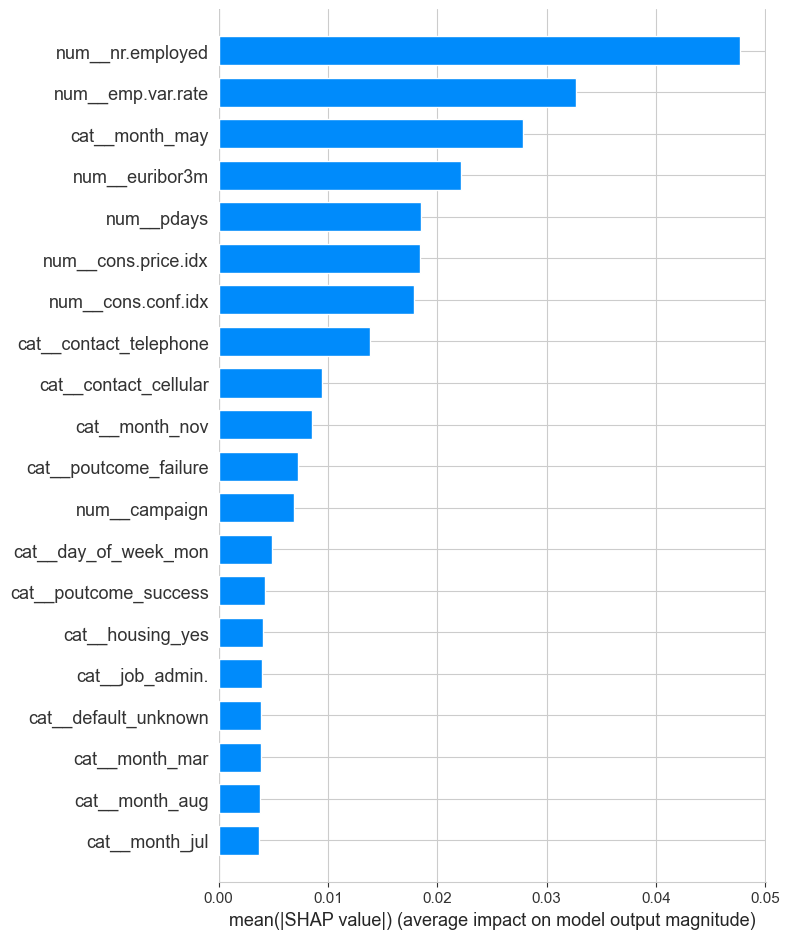

In [12]:
# ---  Model Explainability with SHAP ---
print("\n--- Generating SHAP explanations ---")
import numpy as np # Ensure numpy is imported

# We need to preprocess the data before passing it to the explainer
X_test_processed = nn_pipeline.named_steps['preprocessor'].transform(X_test)
X_train_processed = nn_pipeline.named_steps['preprocessor'].transform(X_train)

# For KernelExplainer, it's good practice to provide a background dataset
background_data = shap.kmeans(X_train_processed, 50) # Summarize with 50 clusters

# FINAL ROBUST PREDICTION FUNCTION
def final_shap_predict_fn(X):
    """
    Handles all output shape inconsistencies from scikeras/keras predict_proba
    and ensures the return value is always a correctly shaped NumPy array for SHAP.
    """
    # Get the raw probabilities from the classifier
    probs = nn_pipeline.named_steps['classifier'].predict_proba(X)

    # Case 1: Output is 1D array (e.g., [0.2, 0.8] for a single sample)
    if probs.ndim == 1:
        # Return the probability of the positive class, wrapped in a new NumPy array
        return np.array([probs[1]])

    # Case 2: Output is 2D array (for a batch of samples)
    else:
        # Return the second column (all probabilities of the positive class)
        return probs[:, 1]

# Create the explainer using the final, robust function
explainer = shap.KernelExplainer(final_shap_predict_fn, background_data)

# Explain the first 100 test samples
print("Calculating SHAP values... (this may take a minute)")
shap_values = explainer.shap_values(X_test_processed[:100])
print("SHAP calculation complete.")

# Get feature names after one-hot encoding
feature_names = nn_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for plotting
X_test_processed_df = pd.DataFrame(X_test_processed[:100], columns=feature_names)

# Plot the SHAP summary
shap.summary_plot(shap_values, X_test_processed_df, plot_type="bar")